In [51]:
%pip install yfinance quandl

import yfinance as yf
import quandl
import pandas as pd

# Download stock data
ticker = 'AAPL'
df_stock = yf.download(ticker, start='2010-01-01', end='2025-07-10')
df_stock
#df_stock.tail()

/tmp/ipython-input-51-3509789903.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_stock = yf.download(ticker, start='2010-01-01', end='2025-07-10')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.431897,6.446624,6.382909,6.414466,493729600
2010-01-05,6.443017,6.479383,6.409056,6.449630,601904800
2010-01-06,6.340532,6.468563,6.333920,6.443017,552160000
2010-01-07,6.328809,6.371487,6.282827,6.363973,477131200
2010-01-08,6.370885,6.371487,6.283128,6.320394,447610800
...,...,...,...,...,...
2025-07-02,212.440002,213.339996,208.139999,208.910004,67941800
2025-07-03,213.550003,214.649994,211.809998,212.149994,34955800


In [52]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Use only the 'Close' column
data = df_stock[['Close']].values

# Normalize the data to scale values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences of 60 days (X) and 1-day-ahead prediction (y)
def create_sequences(data, look_back=60):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i - look_back:i, 0])  # 60 values
        y.append(data[i, 0])                # target value
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data)

# Reshape X for LSTM (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Train/test split (80% train, 20% test)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Training samples: 3073
Testing samples: 769


In [53]:
%pip install tensorflow

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()

# First LSTM layer with Dropout
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Second LSTM layer with Dropout
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer (1 neuron for predicting the stock price)
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step - loss: 0.0103 - val_loss: 0.0011
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 6.5128e-04 - val_loss: 0.0010
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 5.4816e-04 - val_loss: 0.0036
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 4.9396e-04 - val_loss: 8.3133e-04
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 5.1169e-04 - val_loss: 0.0043
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - loss: 5.4266e-04 - val_loss: 0.0070
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 5.0618e-04 - val_loss: 8.5916e-04
Epoch 8/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 4.8987e-04 - val_loss: 7.4603e-04
Epoch 9/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 4.2527e-04 - val_loss: 7.8525e-04
Epoch 10/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 3.9321e-04 - val_loss: 0.0011
Epoch 11/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - loss: 4.2675e-04 - val_loss: 7.8712e-04
Epoch 12

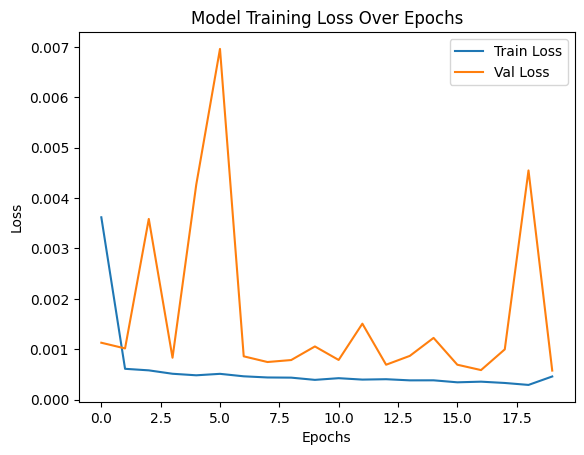

In [55]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Training Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [56]:
#Prediction
predicted_scaled = model.predict(X_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


In [57]:
predicted_scaled = predicted_scaled.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)


#Reverse scaling to get actual prices
predicted_prices = scaler.inverse_transform(predicted_scaled)
actual_prices = scaler.inverse_transform(y_test)

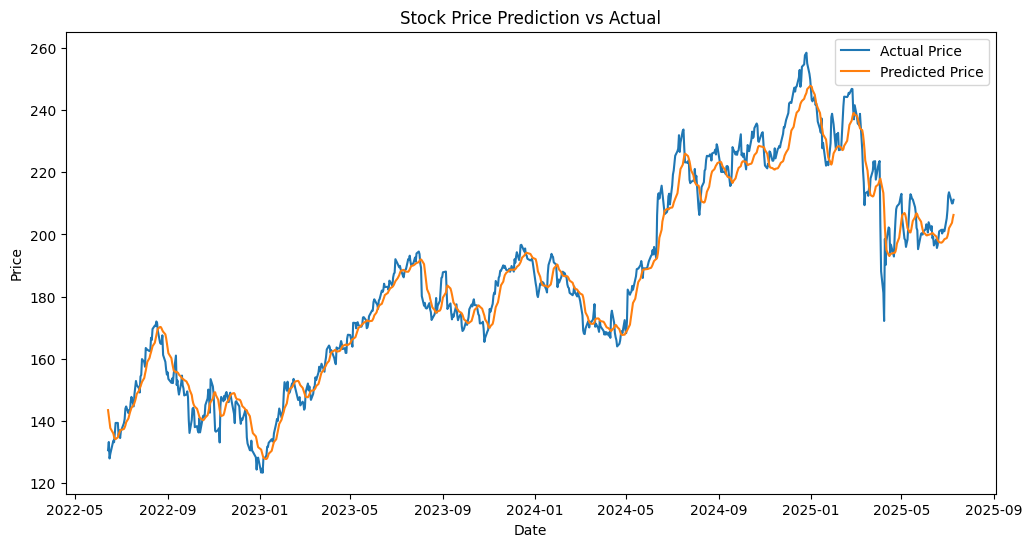

In [58]:
test_dates = df_stock.index[-len(y_test):]

plt.figure(figsize=(12,6))
plt.plot(test_dates, actual_prices, label='Actual Price')
plt.plot(test_dates, predicted_prices, label='Predicted Price')
plt.title("Stock Price Prediction vs Actual")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [59]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
print(f"Fixed RMSE: {rmse:.2f}")

Fixed RMSE: 6.06
